# Задание по генерации и обработке данных

## 1) Сгенерить пайтоном датасет, в котором были бы следующие поля:

- `userid` — 100 уникальных айди пользователей

- `payment_amount` — сумма платежа (рандомное значение), от 5 до 50 платежей у каждого пользователя

- `payment_date` — дата платежа, диапазон дат среди всех пользователей не менее 3-х, но не более 5-ти лет.

attn.: У каждого пользователя должны быть (не менее 3-х) платежи в разные месяца.

Список зависимостей:
```bash
Python==3.8.8
IPython==7.22.0
Faker==15.1.1
matplotlib==3.3.4
pandas==1.2.4
seaborn==0.11.1
```

Импортируем библиотеки.

In [ ]:
import random

from IPython import display as pic_display
from faker import Faker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from uuid import uuid4

fake = Faker()
sns.set_style("whitegrid")

Зададим параметры генерации.

In [ ]:
num_of_user_ids = 100
num_of_payments_range = (5, 50)
payments_amount_range = (1, 100)
start_date, end_date = '-5y', 'now'

Сгенерируем данные и упакуем в датасет.

In [ ]:
df_dict = dict(
    userid=[],
    payment_amount=[],
    payment_date=[],
)

for userid in [str(uuid4()) for _ in range(num_of_user_ids)]:
    for _ in range(random.randint(*num_of_payments_range)):
        df_dict['userid'].append(userid)
        df_dict['payment_amount'].append(random.randint(*payments_amount_range))
        df_dict['payment_date'].append(fake.date_time_between(start_date=start_date, end_date=end_date))

df = pd.DataFrame.from_dict(df_dict).sort_values(by='payment_date').reset_index(drop=True)

In [ ]:
# attn.: для воспроизведения моего результата скачай датасет и раскомментируй этот блок
# df = pd.read_csv('payment_dataset.csv')
# df['payment_date'] = pd.to_datetime(df['payment_date'])

Проверим результат.

In [ ]:
print('Уникальных айди пользователей:', df.userid.nunique(), '\n')
print('Платежей на пользователя (min):', df.groupby('userid').payment_date.count().min())
print('Платежей на пользователя (max):', df.groupby('userid').payment_date.count().max(), '\n')
print('Дата платежа (min):', df.payment_date.min().date())
print('Дата платежа (max):', df.payment_date.max().date(), '\n')
print('Пример платежей одного пользователя:')
display(df[df.userid.isin(df.userid.value_counts(ascending=True).head(1).index)])
print('Всего платежей:', df.shape[0])

Уникальных айди пользователей: 100 

Платежей на пользователя (min): 6
Платежей на пользователя (max): 50 

Дата платежа (min): 2017-10-18
Дата платежа (max): 2022-10-16 

Пример платежей одного пользователя:


,userid,payment_amount,payment_date
358,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,95,2018-06-23 12:20:39
655,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,54,2019-01-02 10:35:25
662,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,46,2019-01-08 10:22:29
1139,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,96,2019-12-18 00:09:57
1997,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,81,2021-07-01 17:46:42
2206,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,46,2021-11-04 16:44:12


Всего платежей: 2715


Проверим, что у каждого пользователя не менее 3-х платежей в разные месяцы.

In [ ]:
# Посчитаем признак год-месяц, позже он пригодится для графиков
df['yr_month'] = df['payment_date'].dt.strftime("%Y-%m")
examination = df.groupby('userid').yr_month.apply(set).apply(len).sort_values()

print(f'Минимум {examination.min()} платежей в разные месяцы:')
display(examination.head().to_frame())

Минимум 5 платежей в разные месяцы:


,yr_month
userid,
1e62e0d2-a025-4e4a-9d57-c8068009bfd9,5
38b7aa6c-1235-482a-bca8-956f98c0dca6,6
e44e5d7b-e127-49c6-bbc1-348d0dbd9088,6
96713f89-fc21-4107-a8c3-bb42d0f5ffd4,7
bc4f07d7-a707-419f-b6aa-a83a61cadf75,7


Сохраним готовый датасет для PostgreSQL.

In [ ]:
dataset_path = 'C:\\dataset\\payment_dataset.csv'
df.to_csv(dataset_path, columns=['userid', 'payment_amount', 'payment_date'], index=False)

## 2) Пайтоном загрузить сгенерированный датасет в таблицу базы данных (postgresql)

Напишем коннектор.

In [ ]:
import psycopg2


class Connector:

    def __init__(self):
        self.params = dict(
            dbname="payments",
            user="postgres",
            password="postgres",
            host='127.0.0.1',
            port=5432,
        )

    def send(self, query):
        try:
            # подключиться к серверу PostgreSQL и создать курсор
            print('Connecting to the PostgreSQL database')
            conn = psycopg2.connect(**self.params)
            cur = conn.cursor()

            # выполнить запрос и закрыть подключение
            print('Executing query')
            cur.execute(query)
            conn.commit()
            cur.close()

        except (Exception, psycopg2.DatabaseError) as error:
            print(error)

        finally:
            if conn:
                conn.close()
                print('Database connection closed')

    def read(self, query):
        conn = psycopg2.connect(**self.params)
        df = pd.read_sql(query, conn)
        conn.close()
        return df


my_psql = Connector()

Создадим таблицу `payments_data`.

In [ ]:
query = '''
        DROP TABLE IF EXISTS payments_data CASCADE;
        CREATE TABLE payments_data
          (
             userid         VARCHAR(36) NOT NULL,
             payment_amount SMALLINT NOT NULL,
             payment_date   TIMESTAMP NOT NULL
          );
        '''
my_psql.send(query)

Connecting to the PostgreSQL database
Executing query
Database connection closed


Загрузим датасет в таблицу `payments_data`.

In [ ]:
query = f'''
        COPY payments_data
          (
             userid,
             payment_amount,
             payment_date
          )
        FROM '{dataset_path}' DELIMITER ',' CSV HEADER;
        '''
my_psql.send(query)

Connecting to the PostgreSQL database
Executing query
Database connection closed


Проверим результат.

In [ ]:
query = '''
        SELECT Count(userid)          AS transactions,
               Count(DISTINCT userid) AS unique_users,
               Min(payment_date)      AS first_payment_date,
               Max(payment_date)      AS last_payment_date
        FROM   payments_data
        '''

display(my_psql.read(query))

,transactions,unique_users,first_payment_date,last_payment_date
0,2715,100,2017-10-18 05:29:28,2022-10-16 14:51:28


## 3) Создать вью которая бы выводила поля:
- month, userid, is_paid, number_of_not_paid
    - month — последовательно месяца с момента первого платежа для пользователя до текущего
    - userid — айди пользователя
    - is_paid — платил ли пользователь в этот месяц
    - number_of_not_paid — количество месяцев прошедших с последнего платежа, если платящий, то 0

Создадим представление `monthly_view`.

In [ ]:
query = '''
CREATE VIEW public.monthly_view AS

-- Добавляем порядковый номер платежа
WITH added_row_number AS (

        SELECT    userid,
                  Date_trunc('month', payment_date),
                  Row_number() OVER(partition BY userid ORDER BY payment_date ASC)
        FROM      payments_data ),

-- Генерируем календарь от первой даты в данных до текущей
calendar AS (

        SELECT    Generate_series(Min(date_trunc), CURRENT_DATE, '1 month')
        FROM      added_row_number ),

-- Объединяем месяцы с платежами и без платежей в одну таблицу
userid_gen_series AS (

        SELECT    userid,
                  generate_series
        FROM     (SELECT *
                  FROM   added_row_number
                  WHERE  row_number = 1) AS u,
        LATERAL  (SELECT *
                  FROM   calendar AS c
                  WHERE  c.generate_series >= u.date_trunc) AS x ),

-- Считаем признак "платил ли клиент"
userid_is_paid AS (

        SELECT    u.generate_series,
                  u.userid,
                 (CASE WHEN a.userid IS NULL THEN 0 ELSE 1 END) AS is_paid,
                  Count(a.rn) OVER (partition BY u.userid ORDER BY u.generate_series, a.rn) AS rn_group
        FROM      userid_gen_series AS u
        LEFT JOIN(SELECT userid,
                         date_trunc,
                         row_number AS rn
                  FROM   added_row_number) AS a
        ON        u.generate_series = a.date_trunc
        AND       u.userid = a.userid )

-- Финальный датасет с признаком "сколько месяцев прошло с последней оплаты"

                  -- DISTINCT дропает случаи нескольких платежей в одном месяце
        SELECT    DISTINCT to_char(generate_series, 'YYYY"-"MM') AS month,
                  userid,
                  is_paid,
                  Row_number() OVER(partition BY userid, rn_group) - 1 AS number_of_not_paid
        FROM      userid_is_paid
        ORDER BY  month;

ALTER TABLE public.monthly_view
    OWNER TO postgres;

'''

my_psql.send(query)

Connecting to the PostgreSQL database
Executing query
Database connection closed


Проверим результат.

In [ ]:
query = f'''
        SELECT    *
        FROM      monthly_view
        WHERE     userid = '{df.userid.value_counts(ascending=True).head(1).index[0]}'
        '''

display(my_psql.read(query).head(10))

,month,userid,is_paid,number_of_not_paid
0,2018-06,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,1,0
1,2018-07,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,1
2,2018-08,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,2
3,2018-09,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,3
4,2018-10,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,4
5,2018-11,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,5
6,2018-12,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,6
7,2019-01,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,1,0
8,2019-02,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,1
9,2019-03,1e62e0d2-a025-4e4a-9d57-c8068009bfd9,0,2


## 4) В пайтоне посчитать MRR для пользователей и вывести его график для топ10 пользователей с максимальными суммарными оплатами

Декомпозируем условие задачи.

> Monthly Recurring Revenue (MRR) is the predictable total revenue generated by your business from all the active subscriptions in a particular month. [[1](https://www.zoho.com/subscriptions/guides/what-is-monthly-recurring-revenue.html#:~:text=How%20to%20calculate%20MRR%3F,revenue%20per%20user%20(ARPU).&text=For%20subscriptions%20under%20annual%20plans,customers%20on%20the%20annual%20plan.)]

Таким образом, чтобы корректно посчитать MRR нужно иметь три сущности:
- вид (триал, обычная, премиум),
- длительность (7 дней, 1 месяц, 12 месяцев),
- стоимость подписки.

Исходя из этого допустим, что все наши клиенты находятся на 1-месячной, невозобновляемой подписке, стоимость которой сильно вариативна и может составлять от 1 до 100 US$ в месяц.

Для упрощения, также допустим, что подписка начинается 1-го и заканчивается последним числом месяца оплаты. Иначе нам было бы удобнее считать метрику по неделям.

> Calculating MRR is simple. Just multiply the number of monthly subscribers by the average revenue per user (ARPU).
>
> **MRR = Number of subscribers under a monthly plan * ARPU**

Таким образом, за число месячных подписчиков мы можем взять число уникальных пользователей совершивших оплату в каждом из месяцев.

> ARPU is calculated by dividing the total revenue by the number of active customers.
>
> **Monthly ARPU = Total MRR (Monthly Recurring Revenue) / Number of active subscriptions** [[2](https://www.zoho.com/subscriptions/general-faq/metrics-and-kpis.html)]

ARPU считается на основе количества активных подписчиков, то есть тех, кто платит деньги. В нашем датасете не встречаются триальные пользователи, поэтому будем считать, что каждый кто совершил оплату является активным подписчиком в этом месяце.

Результируя всё выше сказанное, для поставленной задачи будем считать MRR как общий доход за месяц. Это был бы некорректно для реальных данных, но допустимо в рамках конкретной синтетической задачи, при условии что мы не подгоняем сгенерированные данные.

Посчитаем MRR для всех пользователей.

In [ ]:
mrr = df.groupby('yr_month').agg({'userid': lambda x: len(set(x)), 'payment_amount': 'sum'})

mrr.columns = ['users_count', 'mrr']
mrr['arpu_monthly'] = mrr.mrr / mrr.users_count

display(mrr)

,users_count,mrr,arpu_monthly
yr_month,,,
2017-10,22,1395,63.409091
2017-11,36,2313,64.250000
2017-12,35,2538,72.514286
2018-01,34,2131,62.676471
2018-02,29,2343,80.793103
...,...,...,...
2022-06,30,2058,68.600000
2022-07,43,2238,52.046512
2022-08,27,1732,64.148148


Найдём топ-10 пользователей с максимальными суммарными оплатами.

In [ ]:
top10 = df.groupby('userid').payment_amount.sum().sort_values(ascending=False).head(10).index

Посчитаем MRR для них.

In [ ]:
mrr_top10 = df[df.userid.isin(top10)].groupby('yr_month').agg({'userid': lambda x: len(set(x)), 'payment_amount': 'sum'})

mrr_top10.columns = ['users_count', 'mrr']
mrr_top10['arpu_monthly'] = mrr_top10.mrr / mrr_top10.users_count

display(mrr_top10)
mrr_top10 = mrr_top10.reset_index()

,users_count,mrr,arpu_monthly
yr_month,,,
2017-10,4,231,57.750000
2017-11,5,326,65.200000
2017-12,8,585,73.125000
2018-01,5,442,88.400000
2018-02,7,490,70.000000
...,...,...,...
2022-06,4,317,79.250000
2022-07,7,448,64.000000
2022-08,4,363,90.750000


Нарисуем график.

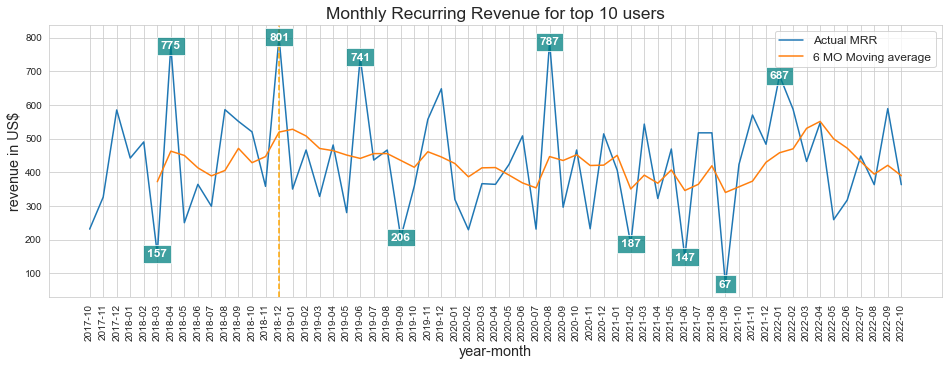

In [ ]:
# Вспомогательные данные
extremes = mrr_top10.sort_values(by='mrr', ascending=False)
peak_value = mrr_top10[mrr_top10.mrr==mrr_top10.mrr.max()].yr_month.values[0]
mrr_top10['moving_average_mrr'] = mrr_top10.mrr.rolling(window=6).mean()

# Графики
plt.figure(figsize=(16, 5))
sns.lineplot(data=mrr_top10, x="yr_month", y="mrr", label='Actual MRR')
sns.lineplot(data=mrr_top10, x="yr_month", y="moving_average_mrr", label='6 MO Moving average')

# Значения на экстремумах
for _, value in pd.concat([extremes.head(5), extremes.tail(5)]).iterrows():
    plt.text(
        x=value.yr_month, y=value.mrr, s=value.mrr,
        ha='center', va='center', fontsize=12, color='white', weight='bold',
        bbox=dict(facecolor='teal', alpha=0.75)
    )

# Оформление
plt.title('Monthly Recurring Revenue for top 10 users', size='xx-large')
plt.xlabel('year-month', size='x-large')
plt.ylabel('revenue in US$', size='x-large')
plt.legend(fontsize=12)
plt.axvline(x=peak_value, color='orange', linestyle='--')
plt.xticks(rotation=90)
plt.show()

## 5) Сохранить данные в файл и построить схожую визуализацию в табло. Дополнительные визуализации приветствуются.

Сохраним данные в файл.

In [ ]:
mrr_top10.to_csv('mrr_top10.csv', index=False)

[Ссылка на визуализацию в Tableau](https://public.tableau.com/views/test_task_16659550741370/Revenue?:language=en-US&:display_count=n&:origin=viz_share_link)

Спасибо за внимание!